In [2]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl

from cryptic_rnn import *

# Functions

# RNN setup

In [3]:
## running function
def get_reps(model, testdata, hidden_size):
    model.eval()
    trials = []
    hiddens = []
    for testset in testdata:
        for x,y in testset:
            for i in range(len(x)):
                hidden_arr = np.empty((0,  hidden_size))
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                    hidden_arr = np.vstack([hidden_arr, hidden.detach().numpy()])
            hiddens.append(hidden_arr)
            trials.append(str(onehot2seq(x)))

    return hiddens, trials 

def fully_trained_rnns(res):

    tests = [r['test'] for r in res]
    cue_dicts = [r['cue_dict'] for r in res]
    acc_train = np.array([r['acc'][:,0] for r in res]).T
    acc_test = np.array([r['acc'][:,1] for r in res]).T
    mods = [r['mod'] for r in res]
    acc_train_p = np.array([r['acc_p'][:,0] for r in res]).T
    acc_test_p = np.array([r['acc_p'][:,1] for r in res]).T
    mods_p = [r['mod_p'] for r in res]
   
    final_accs = pd.DataFrame({'train_acc': acc_train[-1,:], 'test_acc': acc_test[-1,:]}) 
    fully_trained = final_accs[final_accs['train_acc'] == 1]
    ft_test_acc = fully_trained.test_acc
    fully_trained_idx = fully_trained.index
    
    final_accs = pd.DataFrame({'train_acc': acc_train_p[-1,:], 'test_acc_p': acc_test_p[-1,:]}) 
    fully_trained = final_accs[final_accs['train_acc'] == 1]
    ft_test_acc_p = fully_trained.test_acc_p
    fully_trained_idx_p = fully_trained.index
    
    ft_idx = list(fully_trained_idx_p.intersection(fully_trained_idx))
    
    ft_cue_dicts = [cue_dicts[i] for i in ft_idx]
    ft_tests = [tests[i] for i in ft_idx]
    ft_mods = [mods[i] for i in ft_idx]
    ft_mods_p = [mods_p[i] for i in ft_idx]
    
    return ft_mods, ft_mods_p, ft_tests, ft_cue_dicts, ft_test_acc, ft_test_acc_p 
    

def run_exp(trainseqs_old1 , trainseqs_old2 ,testseqs_old1, testseqs_old2, cue_dict,xavier_gain):

    all_syms = list(cue_dict.keys())
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    input_vals.sort() # sort values (so A is smallest)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    trainseqs = change_dict(trainseqs_old1, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset1 = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    
    trainseqs = change_dict(trainseqs_old2, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset2 = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    
    testseqs = change_dict(testseqs_old1, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset1 = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)
    
    testseqs = change_dict(testseqs_old2, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset2 = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers, xavier_gain)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset1, [trainset1, testset1, testset2], epochs1, hidden_size)
    loss2, acc2 = run_acc(model,optimizer,criterion, trainset2, [trainset2, testset1, testset2], epochs2, hidden_size)

    loss =  np.vstack([loss1, loss2])
    acc = np.vstack([acc1, acc2])
    return {'cue_dict':cue_dict, 'loss':loss, 'acc':acc, 'mod': model, 'test1': testset1, 'test2': testset2}

def run_plot(trainseqs1, trainseqs2, testseqs1, testseqs2, cue_dict, xavier_gain):
    t1 = time.time()
    res  = Parallel(n_jobs = -1)(delayed(run_exp)(trainseqs1,trainseqs2, testseqs1,testseqs2, cue_dict, xavier_gain) for i in range(num_sims))
    t2 = time.time()
    print('run time: ', (t2-t1)/60)

    acc_train_list = [r['acc'][:,0] for r in res]
    acc_test_list1 = [r['acc'][:,1] for r in res]
    acc_test_list2 = [r['acc'][:,2] for r in res]
    loss_list = [r['loss'] for r in res]
 
    tests1 = [r['test1'] for r in res]
    tests2 = [r['test2'] for r in res]
    cue_dicts = [r['cue_dict'] for r in res]
    losses = np.hstack([r['loss'] for r in res])
    acc_train = np.array([r['acc'][:,0] for r in res]).T
    acc_test1 = np.array([r['acc'][:,1] for r in res]).T
    acc_test2 = np.array([r['acc'][:,2] for r in res]).T
    mods = [r['mod'] for r in res]
    
    _, _, alldfs = predcorr(mods, tests1, hidden_size, plot_corr = True)
    _, _, alldfs = predcorr(mods, tests2, hidden_size, plot_corr = True)
    
    plotNNs([losses], [acc_train, acc_test1, acc_test2], \
            ['train', 'test1', 'test2'], colors = ['green', 'orange', 'red'], title = '', shift = 0)
    
    final_accs = pd.DataFrame({'train_acc': acc_train[-1,:],'test_acc1': acc_test1[-1,:], 'test_acc2': acc_test2[-1,:]}) 
    
    fully_trained = final_accs[final_accs['train_acc'] == 1]
    fully_trained_idx = fully_trained.index
    fully_trained_test_acc1 = fully_trained['test_acc1'].mean() 
    fully_trained_test_acc_std1 = fully_trained['test_acc1'].std()
    fully_trained_test_acc2 = fully_trained['test_acc2'].mean() 
    fully_trained_test_acc_std2 = fully_trained['test_acc2'].std()
    
    ft_mods = [mods[i] for i in fully_trained_idx]
    print(len(ft_mods))
    ft_tests1 = [tests1[i] for i in fully_trained_idx]
    ft_tests2 = [tests2[i] for i in fully_trained_idx]
    ft_tests_acc1 = np.array([acc_test_list1[i] for i in fully_trained_idx]).T
    ft_tests_acc2 = np.array([acc_test_list2[i] for i in fully_trained_idx]).T
    ft_train_acc = np.array([acc_train_list[i] for i in fully_trained_idx]).T
    ft_loss = np.hstack([loss_list[i] for i in fully_trained_idx])
    
    if len(ft_mods) > 0:
        plt.figure()
        _, dfs1, alldfs = predcorr(ft_mods, ft_tests1, hidden_size, plot_corr = True)
        plt.figure()
        _, dfs2, alldfs = predcorr(ft_mods, ft_tests2, hidden_size, plot_corr = True)
    else:
        r2, dfs, alldfs = 0, 0, 0
    
    plotNNs([ft_loss], [ft_train_acc, ft_tests_acc1, ft_tests_acc2], \
            ['train', 'test1', 'test2'], colors = ['green', 'orange', 'red'], title = '', shift = 0)
   
    acc_df = pd.DataFrame({'acc_train': acc_train[-1,:], 'acc_test1': acc_test1[-1,:], 'acc_test2': acc_test2[-1,:]})
    
    return {'res':res,'mods':mods ,'dfs1': dfs1, 'dfs2': dfs2,\
            'tests1': tests1, 'tests2': tests2,'cue_dicts': cue_dicts, 'acc_df':acc_df }


def generate_pos_primitives(inputs, cue_dict):
    seq = []
    for inp in inputs:
        trial = [('+', inp), '=']
        trial.append(cue_dict[inp])
        seq.append(trial)
    return seq



In [4]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005

## running params
epochs = 12
num_sims = 8

# 
xavier_gain = 0.001

# Experiments

Final accuracy against ratio of other/self



In [5]:
add = '+'
sub = '-'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)
primitives = generate_primitives(all_syms, cue_dict)
print(primitives)
neg_primitives = generate_neg_primitives(all_syms, cue_dict)
print(neg_primitives)
pos_primitives = generate_pos_primitives(all_syms, cue_dict)
print(pos_primitives)

{'A': 15, 'B': 9, 'C': 7, 'D': 12}
[['A', '=', 15], ['B', '=', 9], ['C', '=', 7], ['D', '=', 12]]
[[('-', 'A'), '=', -15], [('-', 'B'), '=', -9], [('-', 'C'), '=', -7], [('-', 'D'), '=', -12]]
[[('+', 'A'), '=', 15], [('+', 'B'), '=', 9], [('+', 'C'), '=', 7], [('+', 'D'), '=', 12]]


# Run

trainseqs  [[('+', 'A'), ('+', 'B'), '=', 24], [('+', 'B'), ('+', 'C'), '=', 16], [('+', 'C'), ('+', 'D'), '=', 19], [('+', 'D'), ('+', 'A'), '=', 27], [('+', 'A'), '=', 15], [('+', 'B'), '=', 9], [('+', 'C'), '=', 7], [('+', 'D'), '=', 12]]
testseqs  [[('+', 'A'), ('+', 'A'), '=', 30], [('+', 'A'), ('+', 'C'), '=', 22], [('+', 'A'), ('+', 'D'), '=', 27], [('+', 'B'), ('+', 'A'), '=', 24], [('+', 'B'), ('+', 'B'), '=', 18], [('+', 'B'), ('+', 'D'), '=', 21], [('+', 'C'), ('+', 'A'), '=', 22], [('+', 'C'), ('+', 'B'), '=', 16], [('+', 'C'), ('+', 'C'), '=', 14], [('+', 'D'), ('+', 'B'), '=', 21], [('+', 'D'), ('+', 'C'), '=', 19], [('+', 'D'), ('+', 'D'), '=', 24]]
run time:  3.6941083510716757
8


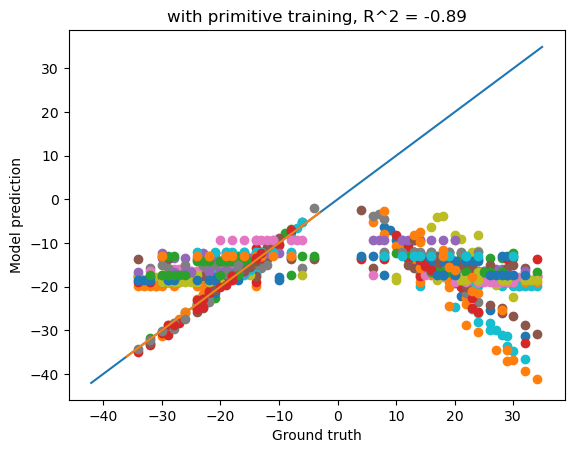

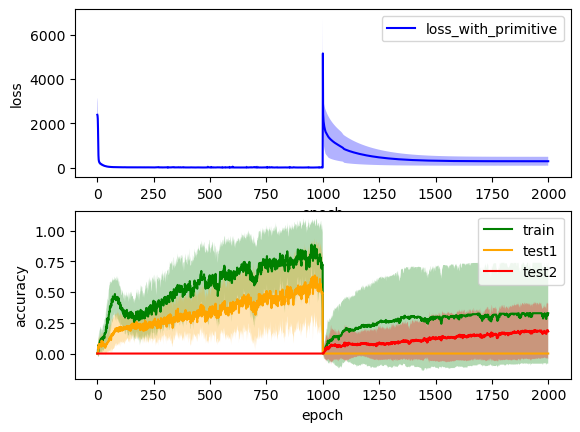

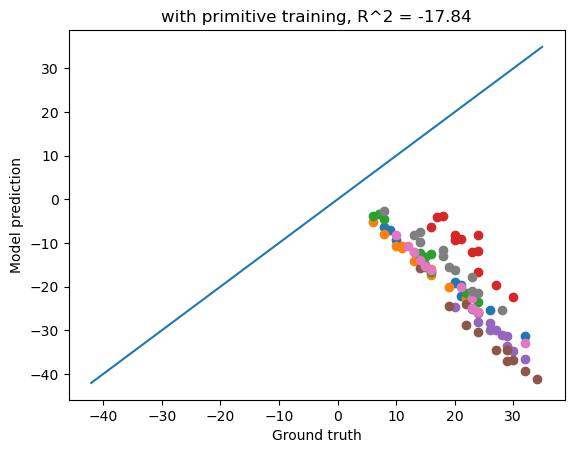

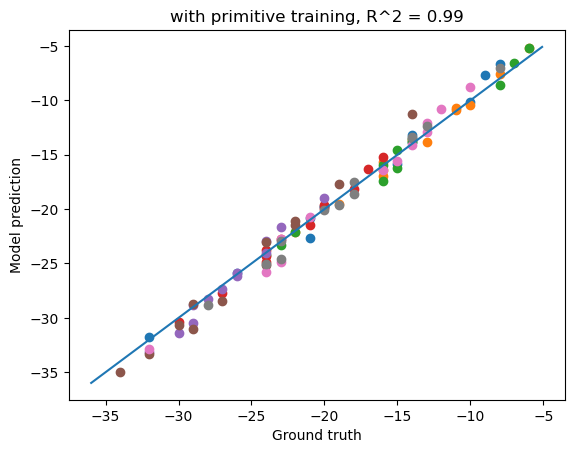

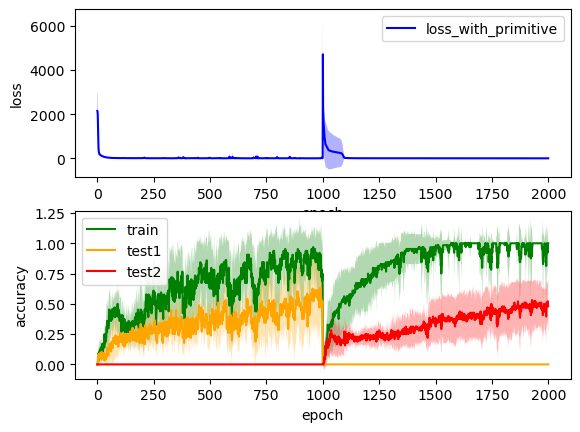

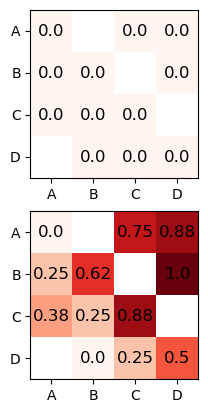

In [6]:
epochs1 = 1000
epochs2 = 1000

num_sims = 32

xavier_gain = 0.001

trainseqs1 = generate_pos_other(add, all_syms, cue_dict)+ pos_primitives
trainseqs2 = generate_neg_other(sub, all_syms, cue_dict)+ neg_primitives
testseqs_add = generate_pos_trials(add, all_syms, all_syms, cue_dict)
testseqs_sub = generate_neg_trials(sub, all_syms, all_syms, cue_dict)
testseqs_add = [seq for seq in testseqs_add  if seq not in trainseqs1]
testseqs_sub = [seq for seq in testseqs_sub if seq not in trainseqs2]

print('trainseqs ', trainseqs1)
print('testseqs ', testseqs_add)
res1 = run_plot(trainseqs1, trainseqs2, testseqs_add, testseqs_sub, cue_dict, xavier_gain)

fig, ax = plt.subplots(2,1)
heatmap_acc_sign(num_inputs, res1['dfs1'], ax[0])
heatmap_acc_sign(num_inputs, res1['dfs2'], ax[1])

trainseqs  [[('+', 'A'), ('+', 'B'), '=', 24], [('+', 'B'), ('+', 'C'), '=', 16], [('+', 'C'), ('+', 'D'), '=', 19], [('+', 'D'), ('+', 'A'), '=', 27], [('+', 'A'), '=', 15], [('+', 'B'), '=', 9], [('+', 'C'), '=', 7], [('+', 'D'), '=', 12]]
testseqs  [[('+', 'A'), ('+', 'A'), '=', 30], [('+', 'A'), ('+', 'C'), '=', 22], [('+', 'A'), ('+', 'D'), '=', 27], [('+', 'B'), ('+', 'A'), '=', 24], [('+', 'B'), ('+', 'B'), '=', 18], [('+', 'B'), ('+', 'D'), '=', 21], [('+', 'C'), ('+', 'A'), '=', 22], [('+', 'C'), ('+', 'B'), '=', 16], [('+', 'C'), ('+', 'C'), '=', 14], [('+', 'D'), ('+', 'B'), '=', 21], [('+', 'D'), ('+', 'C'), '=', 19], [('+', 'D'), ('+', 'D'), '=', 24]]
run time:  9.017188982168834
7


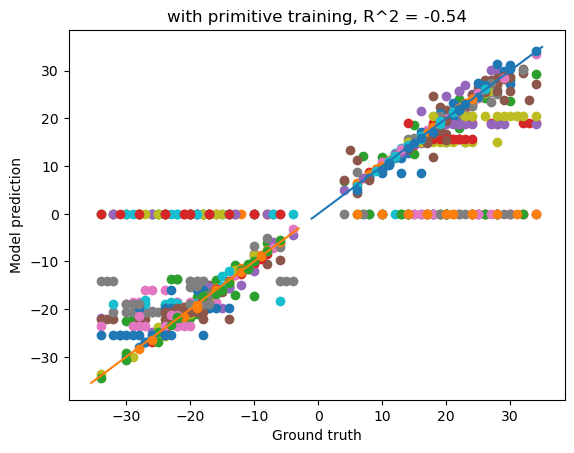

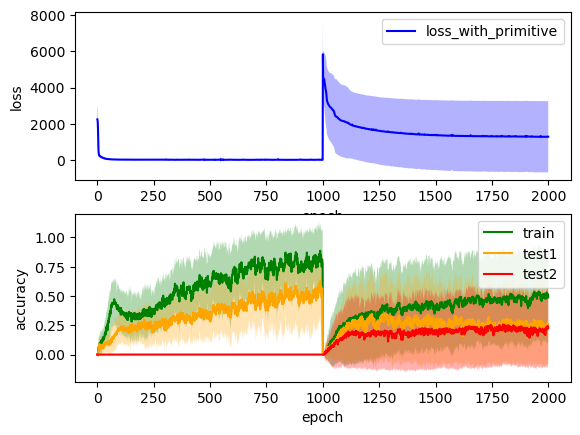

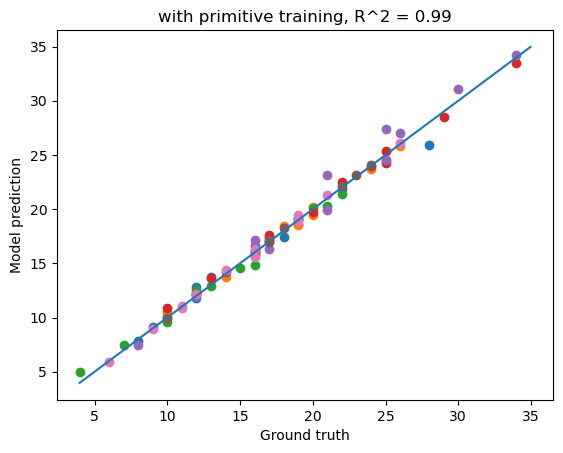

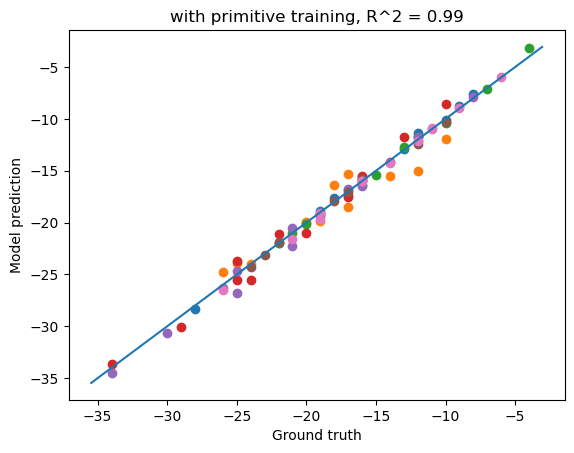

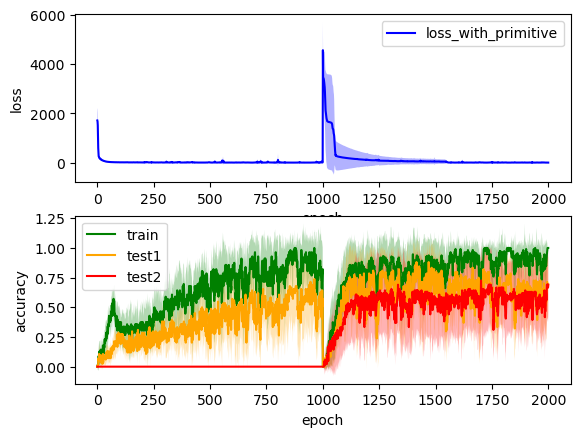

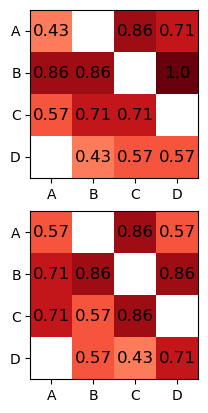

In [7]:
epochs1 = 1000
epochs2 = 1000

num_sims = 32

xavier_gain = 0.001

trainseqs1 = generate_pos_other(add, all_syms, cue_dict)+ pos_primitives
trainseqs2 = generate_neg_other(sub, all_syms, cue_dict)+ neg_primitives + trainseqs1
testseqs_add = generate_pos_trials(add, all_syms, all_syms, cue_dict)
testseqs_sub = generate_neg_trials(sub, all_syms, all_syms, cue_dict)
testseqs_add = [seq for seq in testseqs_add  if seq not in trainseqs1]
testseqs_sub = [seq for seq in testseqs_sub if seq not in trainseqs2]

print('trainseqs ', trainseqs1)
print('testseqs ', testseqs_add)
res1 = run_plot(trainseqs1, trainseqs2, testseqs_add, testseqs_sub, cue_dict, xavier_gain)

fig, ax = plt.subplots(2,1)
heatmap_acc_sign(num_inputs, res1['dfs1'], ax[0])
heatmap_acc_sign(num_inputs, res1['dfs2'], ax[1])

trainseqs  [[('+', 'A'), ('+', 'B'), '=', 24], [('+', 'B'), ('+', 'C'), '=', 16], [('+', 'C'), ('+', 'D'), '=', 19], [('+', 'D'), ('+', 'A'), '=', 27], [('+', 'A'), '=', 15], [('+', 'B'), '=', 9], [('+', 'C'), '=', 7], [('+', 'D'), '=', 12]]
testseqs  [[('+', 'A'), ('-', 'A'), '=', 0], [('+', 'A'), ('-', 'B'), '=', 6], [('+', 'A'), ('-', 'C'), '=', 8], [('+', 'A'), ('-', 'D'), '=', 3], [('+', 'B'), ('-', 'A'), '=', -6], [('+', 'B'), ('-', 'B'), '=', 0], [('+', 'B'), ('-', 'C'), '=', 2], [('+', 'B'), ('-', 'D'), '=', -3], [('+', 'C'), ('-', 'A'), '=', -8], [('+', 'C'), ('-', 'B'), '=', -2], [('+', 'C'), ('-', 'C'), '=', 0], [('+', 'C'), ('-', 'D'), '=', -5], [('+', 'D'), ('-', 'A'), '=', -3], [('+', 'D'), ('-', 'B'), '=', 3], [('+', 'D'), ('-', 'C'), '=', 5], [('+', 'D'), ('-', 'D'), '=', 0]]
run time:  7.615327735741933
9


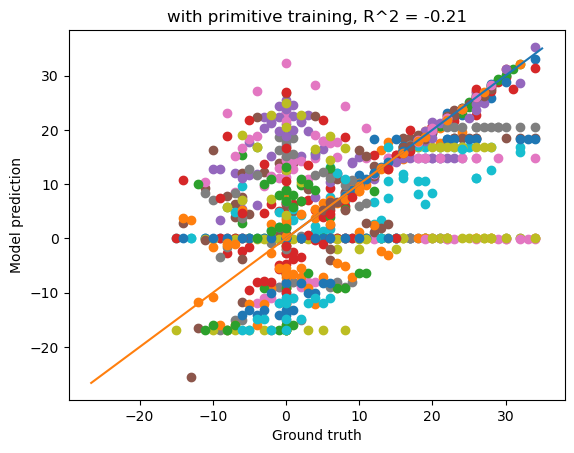

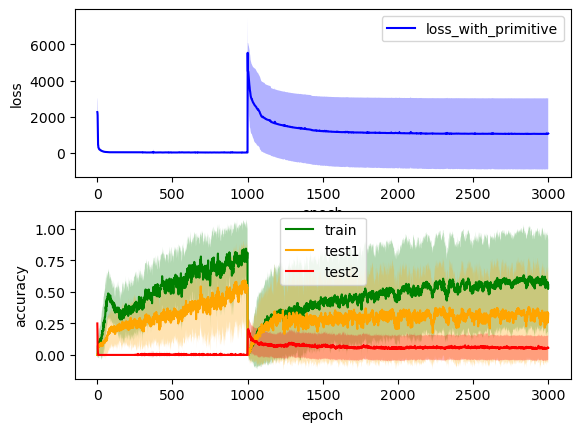

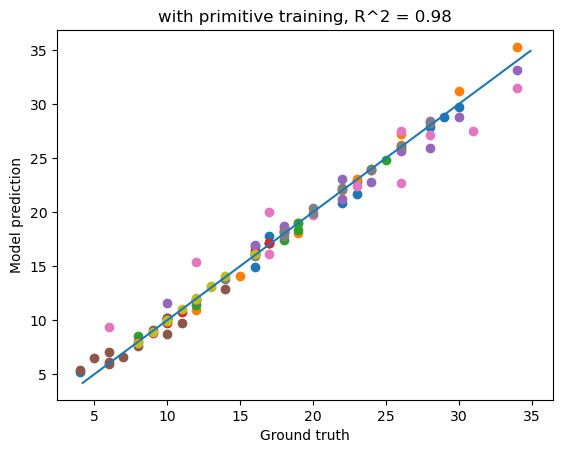

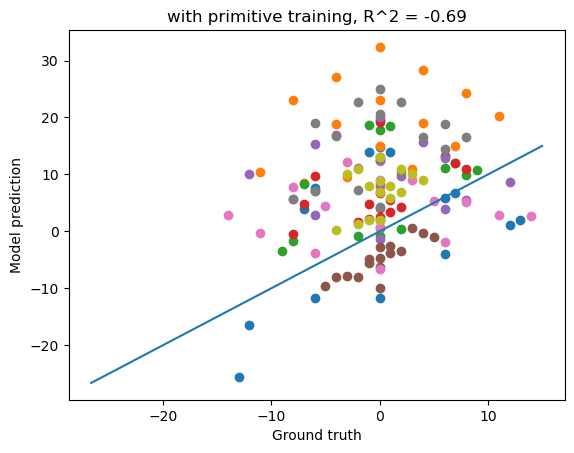

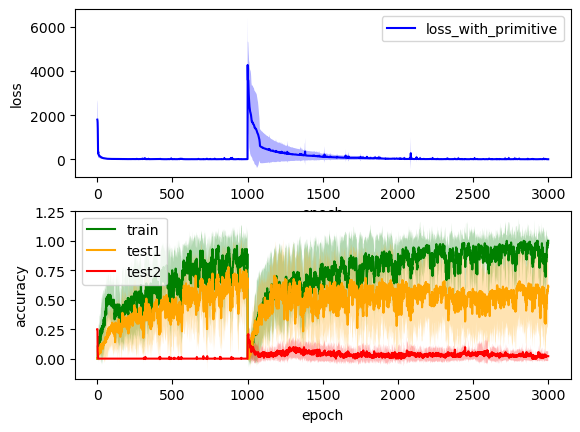

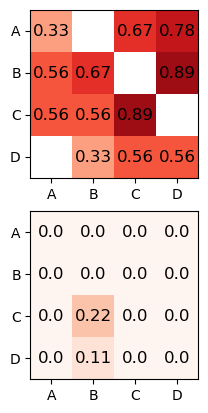

In [11]:
epochs1 = 1000
epochs2 = 2000

num_sims = 32

xavier_gain = 0.001

trainseqs1 = generate_pos_other(add, all_syms, cue_dict)+ pos_primitives
trainseqs2 = generate_neg_other(sub, all_syms, cue_dict)+ neg_primitives + trainseqs1
testseqs_add = generate_pos_trials(add, all_syms, all_syms, cue_dict)
testseqs_sub = generate_neg_trials(sub, all_syms, all_syms, cue_dict)
testseqs_neg_add = generate_neg_trials(add, all_syms, all_syms, cue_dict)
testseqs_pos_sub = generate_pos_trials(sub, all_syms, all_syms, cue_dict)

testseqs_add = [seq for seq in testseqs_add  if seq not in trainseqs1]
testseqs_sub = [seq for seq in testseqs_sub if seq not in trainseqs2]


print('trainseqs ', trainseqs1)
print('testseqs ', testseqs_pos_sub)
res1 = run_plot(trainseqs1, trainseqs2, testseqs_add, testseqs_pos_sub, cue_dict, xavier_gain)

fig, ax = plt.subplots(2,1)
heatmap_acc_sign(num_inputs, res1['dfs1'], ax[0])
heatmap_acc_sign(num_inputs, res1['dfs2'], ax[1])

trainseqs  [[('+', 'A'), ('+', 'B'), '=', 24], [('+', 'B'), ('+', 'C'), '=', 16], [('+', 'C'), ('+', 'D'), '=', 19], [('+', 'D'), ('+', 'A'), '=', 27], [('+', 'A'), '=', 15], [('+', 'B'), '=', 9], [('+', 'C'), '=', 7], [('+', 'D'), '=', 12]]
testseqs  [[('+', 'A'), ('-', 'A'), '=', 0], [('+', 'A'), ('-', 'B'), '=', 6], [('+', 'A'), ('-', 'C'), '=', 8], [('+', 'A'), ('-', 'D'), '=', 3], [('+', 'B'), ('-', 'A'), '=', -6], [('+', 'B'), ('-', 'B'), '=', 0], [('+', 'B'), ('-', 'C'), '=', 2], [('+', 'B'), ('-', 'D'), '=', -3], [('+', 'C'), ('-', 'A'), '=', -8], [('+', 'C'), ('-', 'B'), '=', -2], [('+', 'C'), ('-', 'C'), '=', 0], [('+', 'C'), ('-', 'D'), '=', -5], [('+', 'D'), ('-', 'A'), '=', -3], [('+', 'D'), ('-', 'B'), '=', 3], [('+', 'D'), ('-', 'C'), '=', 5], [('+', 'D'), ('-', 'D'), '=', 0]]
run time:  7.592470049858093
17


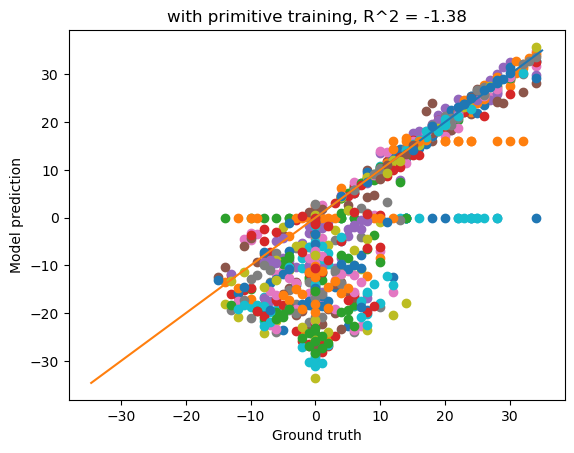

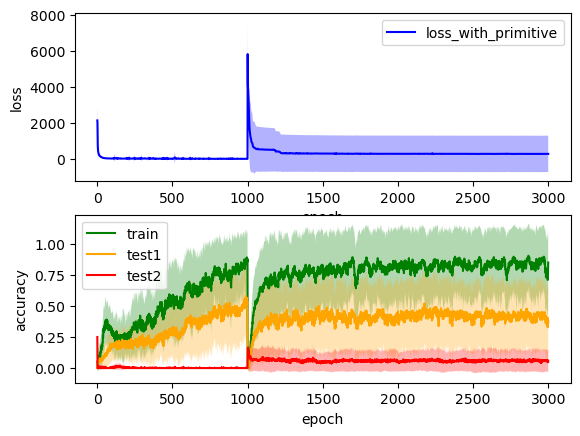

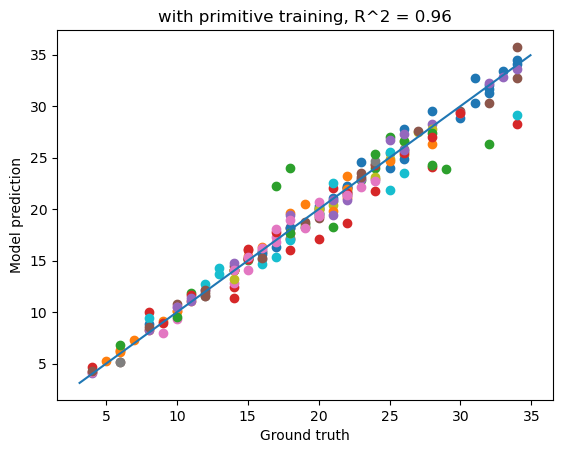

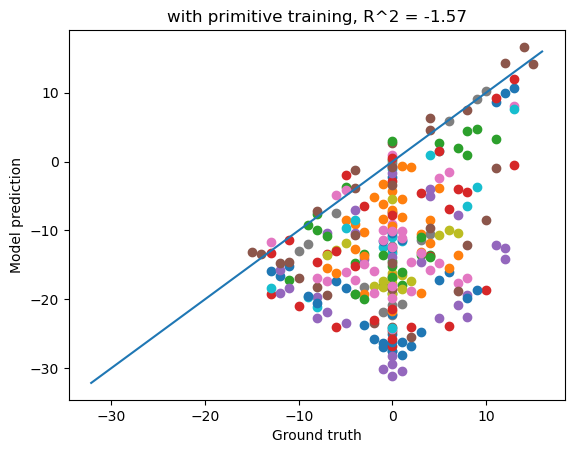

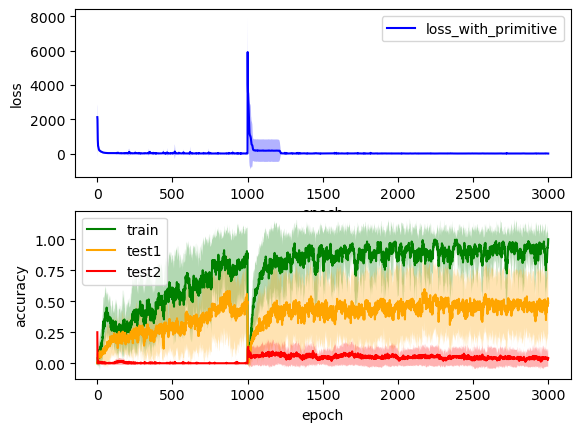

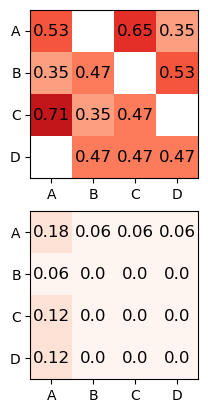

In [15]:
epochs1 = 1000
epochs2 = 2000

num_sims = 32

xavier_gain = 0.001

trainseqs1 = generate_pos_other(add, all_syms, cue_dict)+ pos_primitives
trainseqs2 = generate_neg_other(sub, all_syms, cue_dict)+ neg_primitives + trainseqs1
testseqs_add = generate_pos_trials(add, all_syms, all_syms, cue_dict)
testseqs_sub = generate_neg_trials(sub, all_syms, all_syms, cue_dict)
testseqs_neg_add = generate_neg_trials(add, all_syms, all_syms, cue_dict)
testseqs_pos_sub = generate_pos_trials(sub, all_syms, all_syms, cue_dict)

testseqs_add = [seq for seq in testseqs_add  if seq not in trainseqs1]
testseqs_sub = [seq for seq in testseqs_sub if seq not in trainseqs2]


print('trainseqs ', trainseqs1)
print('testseqs ', testseqs_pos_sub)
res1 = run_plot(trainseqs1, trainseqs2, testseqs_add, testseqs_neg_add, cue_dict, xavier_gain)

fig, ax = plt.subplots(2,1)
heatmap_acc_sign(num_inputs, res1['dfs1'], ax[0])
heatmap_acc_sign(num_inputs, res1['dfs2'], ax[1])

trainseqs  [['A', ('+', 'B'), '=', 24], ['B', ('+', 'C'), '=', 16], ['C', ('+', 'D'), '=', 19], ['D', ('+', 'A'), '=', 27], ['A', '=', 15], ['B', '=', 9], ['C', '=', 7], ['D', '=', 12], [('+', 'A'), '=', 15], [('+', 'B'), '=', 9], [('+', 'C'), '=', 7], [('+', 'D'), '=', 12]]
testseqs  [[('+', 'A'), ('-', 'A'), '=', 0], [('+', 'A'), ('-', 'B'), '=', 6], [('+', 'A'), ('-', 'C'), '=', 8], [('+', 'A'), ('-', 'D'), '=', 3], [('+', 'B'), ('-', 'A'), '=', -6], [('+', 'B'), ('-', 'B'), '=', 0], [('+', 'B'), ('-', 'C'), '=', 2], [('+', 'B'), ('-', 'D'), '=', -3], [('+', 'C'), ('-', 'A'), '=', -8], [('+', 'C'), ('-', 'B'), '=', -2], [('+', 'C'), ('-', 'C'), '=', 0], [('+', 'C'), ('-', 'D'), '=', -5], [('+', 'D'), ('-', 'A'), '=', -3], [('+', 'D'), ('-', 'B'), '=', 3], [('+', 'D'), ('-', 'C'), '=', 5], [('+', 'D'), ('-', 'D'), '=', 0]]
run time:  7.3784934480985
20


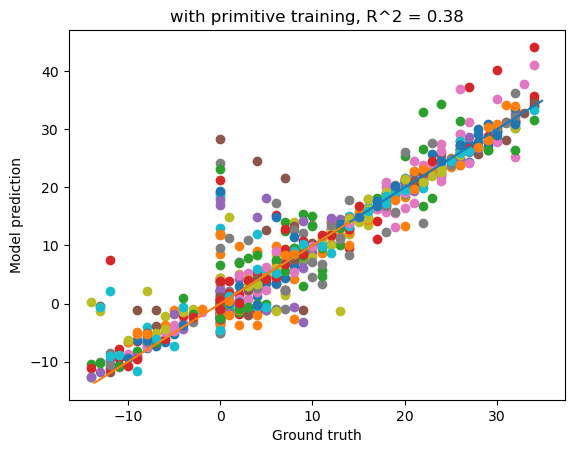

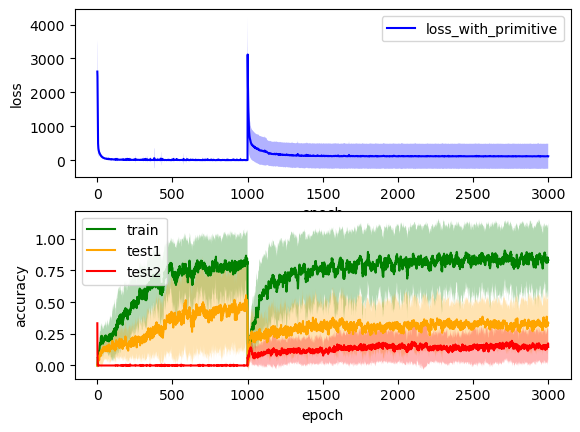

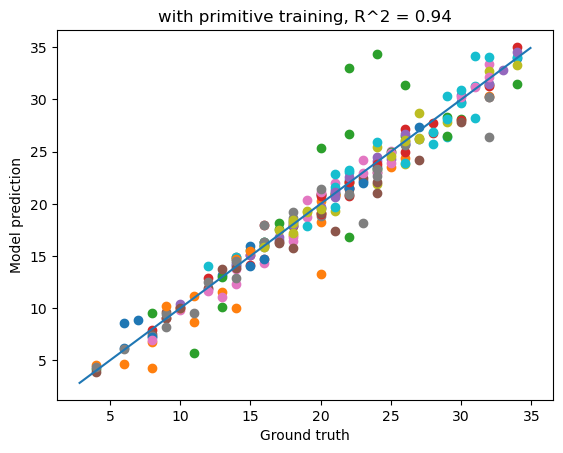

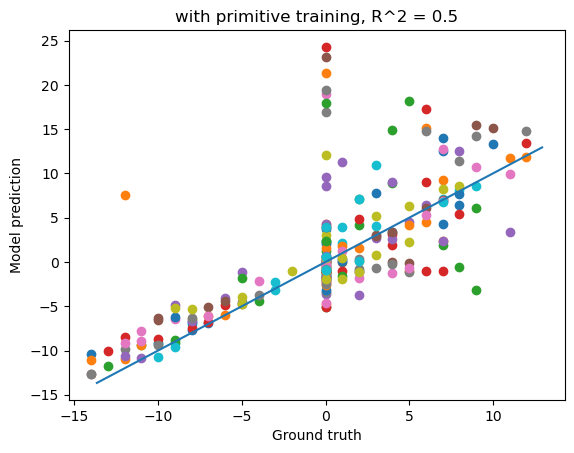

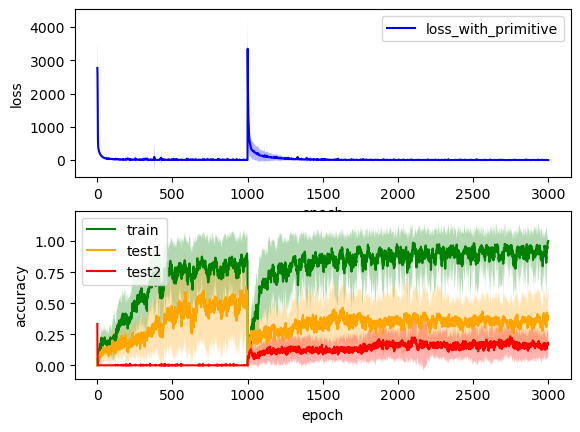

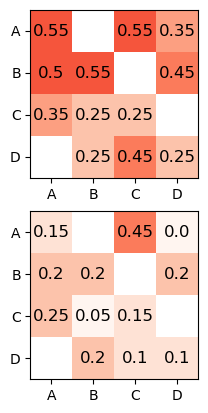

In [12]:
epochs1 = 1000
epochs2 = 2000

num_sims = 32

xavier_gain = 0.001

trainseqs1 = generate_other(add, all_syms, cue_dict)+ primitives + pos_primitives
trainseqs2 = generate_other(sub, all_syms, cue_dict)+ neg_primitives + trainseqs1
testseqs_add = generate_trials(add, all_syms, all_syms, cue_dict)
testseqs_sub = generate_trials(sub, all_syms, all_syms, cue_dict)
testseqs_add = [seq for seq in testseqs_add  if seq not in trainseqs1]
testseqs_sub = [seq for seq in testseqs_sub if seq not in trainseqs2]


print('trainseqs ', trainseqs1)
print('testseqs ', testseqs_pos_sub)
res1 = run_plot(trainseqs1, trainseqs2, testseqs_add, testseqs_sub, cue_dict, xavier_gain)

fig, ax = plt.subplots(2,1)
heatmap_acc(num_inputs, res1['dfs1'], ax[0])
heatmap_acc(num_inputs, res1['dfs2'], ax[1])

trainseqs  [['A', ('+', 'B'), '=', 24], ['B', ('+', 'C'), '=', 16], ['C', ('+', 'D'), '=', 19], ['D', ('+', 'A'), '=', 27], ['A', '=', 15], ['B', '=', 9], ['C', '=', 7], ['D', '=', 12], [('+', 'A'), '=', 15], [('+', 'B'), '=', 9], [('+', 'C'), '=', 7], [('+', 'D'), '=', 12]]
testseqs  [[('+', 'A'), ('-', 'A'), '=', 0], [('+', 'A'), ('-', 'B'), '=', 6], [('+', 'A'), ('-', 'C'), '=', 8], [('+', 'A'), ('-', 'D'), '=', 3], [('+', 'B'), ('-', 'A'), '=', -6], [('+', 'B'), ('-', 'B'), '=', 0], [('+', 'B'), ('-', 'C'), '=', 2], [('+', 'B'), ('-', 'D'), '=', -3], [('+', 'C'), ('-', 'A'), '=', -8], [('+', 'C'), ('-', 'B'), '=', -2], [('+', 'C'), ('-', 'C'), '=', 0], [('+', 'C'), ('-', 'D'), '=', -5], [('+', 'D'), ('-', 'A'), '=', -3], [('+', 'D'), ('-', 'B'), '=', 3], [('+', 'D'), ('-', 'C'), '=', 5], [('+', 'D'), ('-', 'D'), '=', 0]]
run time:  7.413284349441528
19


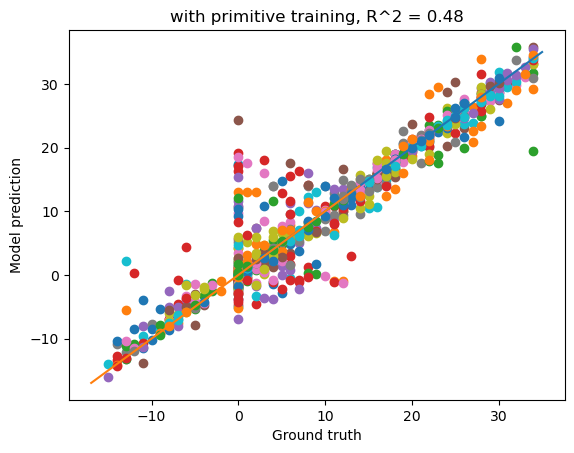

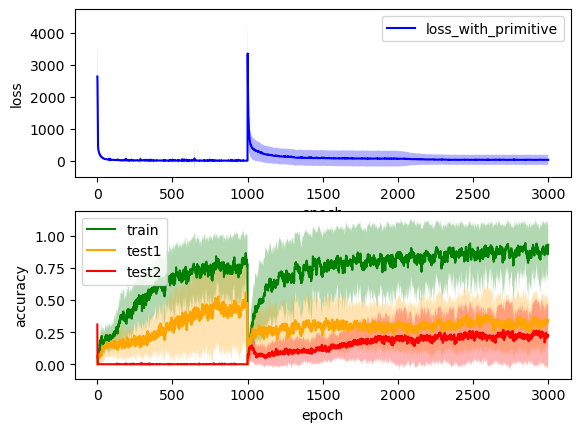

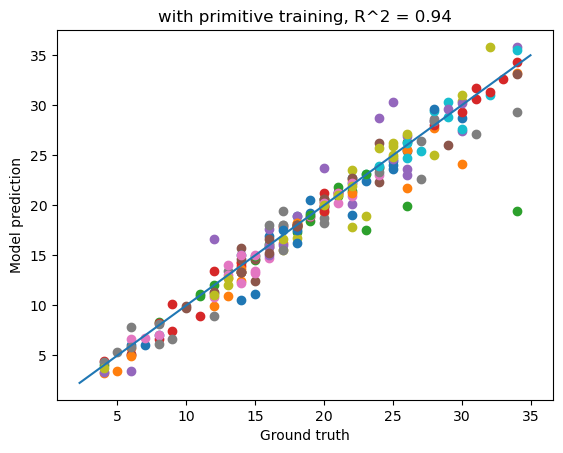

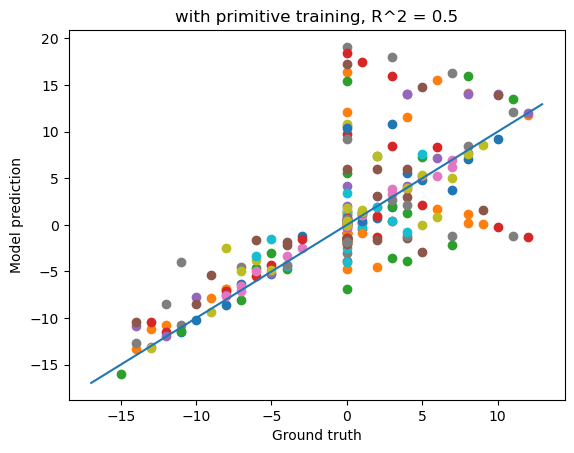

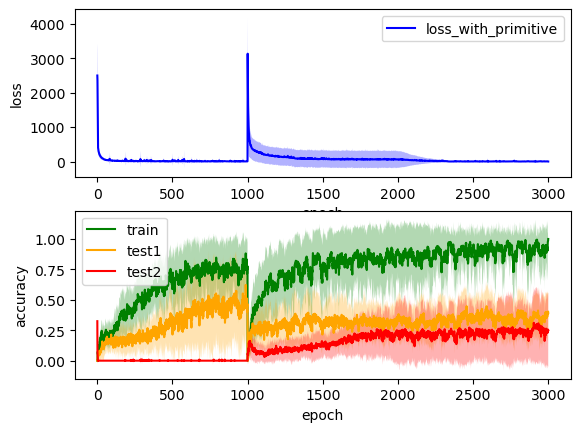

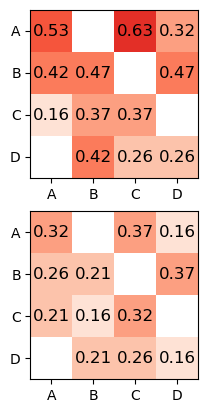

In [13]:
epochs1 = 1000
epochs2 = 2000

num_sims = 32

xavier_gain = 0.00001

trainseqs1 = generate_other(add, all_syms, cue_dict)+ primitives + pos_primitives
trainseqs2 = generate_other(sub, all_syms, cue_dict)+ neg_primitives + trainseqs1
testseqs_add = generate_trials(add, all_syms, all_syms, cue_dict)
testseqs_sub = generate_trials(sub, all_syms, all_syms, cue_dict)
testseqs_add = [seq for seq in testseqs_add  if seq not in trainseqs1]
testseqs_sub = [seq for seq in testseqs_sub if seq not in trainseqs2]


print('trainseqs ', trainseqs1)
print('testseqs ', testseqs_pos_sub)
res1 = run_plot(trainseqs1, trainseqs2, testseqs_add, testseqs_sub, cue_dict, xavier_gain)

fig, ax = plt.subplots(2,1)
heatmap_acc(num_inputs, res1['dfs1'], ax[0])
heatmap_acc(num_inputs, res1['dfs2'], ax[1])

trainseqs  [['A', ('+', 'B'), '=', 24], ['B', ('+', 'C'), '=', 16], ['C', ('+', 'D'), '=', 19], ['D', ('+', 'A'), '=', 27], ['A', '=', 15], ['B', '=', 9], ['C', '=', 7], ['D', '=', 12], [('+', 'A'), '=', 15], [('+', 'B'), '=', 9], [('+', 'C'), '=', 7], [('+', 'D'), '=', 12]]
testseqs  [[('+', 'A'), ('-', 'A'), '=', 0], [('+', 'A'), ('-', 'B'), '=', 6], [('+', 'A'), ('-', 'C'), '=', 8], [('+', 'A'), ('-', 'D'), '=', 3], [('+', 'B'), ('-', 'A'), '=', -6], [('+', 'B'), ('-', 'B'), '=', 0], [('+', 'B'), ('-', 'C'), '=', 2], [('+', 'B'), ('-', 'D'), '=', -3], [('+', 'C'), ('-', 'A'), '=', -8], [('+', 'C'), ('-', 'B'), '=', -2], [('+', 'C'), ('-', 'C'), '=', 0], [('+', 'C'), ('-', 'D'), '=', -5], [('+', 'D'), ('-', 'A'), '=', -3], [('+', 'D'), ('-', 'B'), '=', 3], [('+', 'D'), ('-', 'C'), '=', 5], [('+', 'D'), ('-', 'D'), '=', 0]]
run time:  7.433370780944824
19


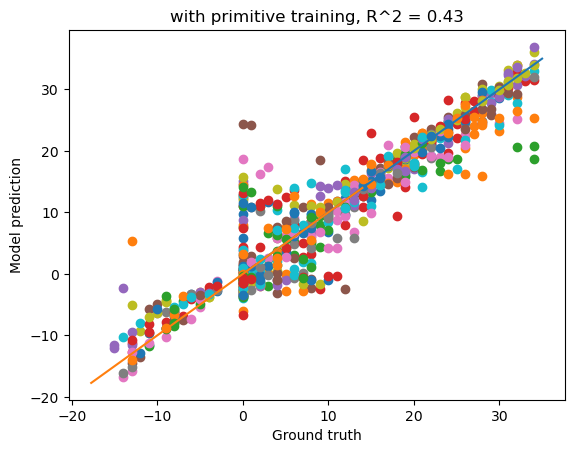

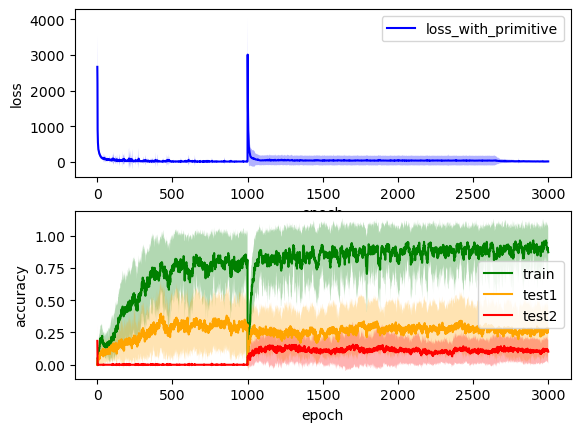

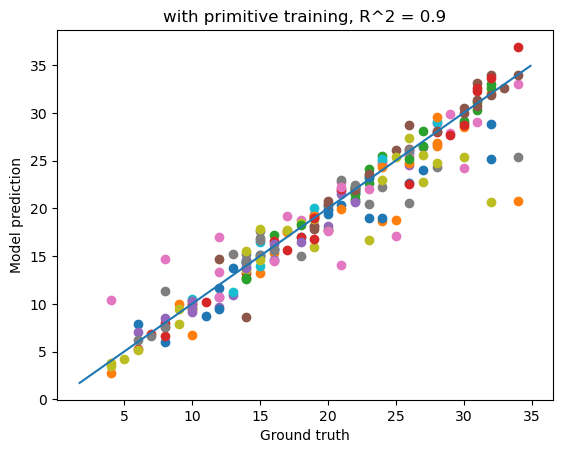

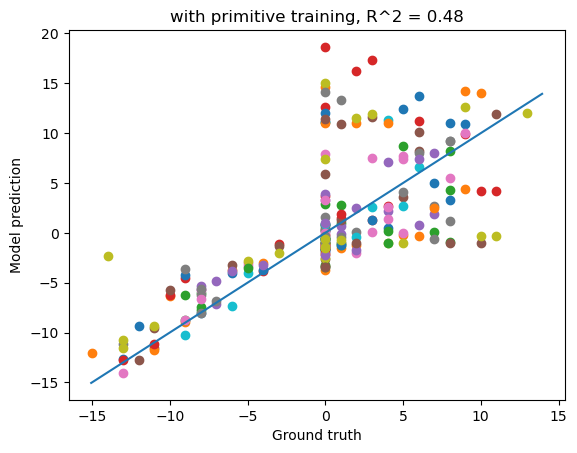

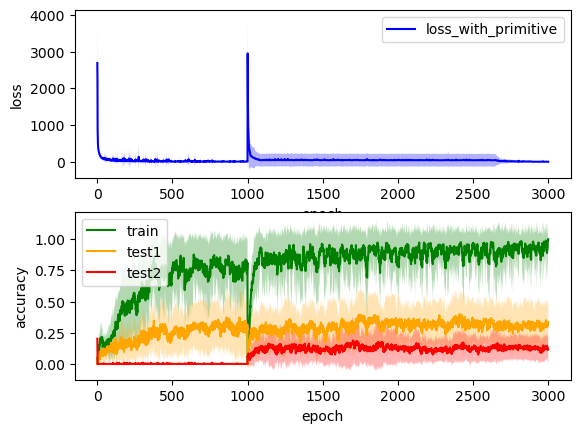

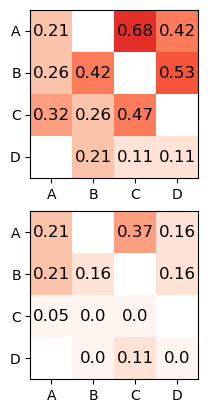

In [14]:
epochs1 = 1000
epochs2 = 2000

num_sims = 32
hidden_size = 40
xavier_gain = 0.001

trainseqs1 = generate_other(add, all_syms, cue_dict)+ primitives + pos_primitives
trainseqs2 = generate_other(sub, all_syms, cue_dict)+ neg_primitives + trainseqs1
testseqs_add = generate_trials(add, all_syms, all_syms, cue_dict)
testseqs_sub = generate_trials(sub, all_syms, all_syms, cue_dict)
testseqs_add = [seq for seq in testseqs_add  if seq not in trainseqs1]
testseqs_sub = [seq for seq in testseqs_sub if seq not in trainseqs2]


print('trainseqs ', trainseqs1)
print('testseqs ', testseqs_pos_sub)
res1 = run_plot(trainseqs1, trainseqs2, testseqs_add, testseqs_sub, cue_dict, xavier_gain)

fig, ax = plt.subplots(2,1)
heatmap_acc(num_inputs, res1['dfs1'], ax[0])
heatmap_acc(num_inputs, res1['dfs2'], ax[1])